In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv

In [2]:
data_nase = pd.read_csv('out.c-cleaning.ALL_POSITIONS_NEW.csv', encoding='utf-8', low_memory=False)

In [3]:
data_Honza = pd.read_csv('out.c-cleaning.ALL_HONZA_NEW.csv', encoding='utf-8', low_memory=False)

In [4]:
data_wkend = pd.read_csv('out.c-cleaning.ALL_HONZA_NEW_WKEND.csv', encoding='utf-8', low_memory=False)

In [8]:
data = pd.concat([data_nase, data_Honza, data_wkend], ignore_index = True)
data = data.dropna(axis=0,subset=['DELAY'],how='any')
data.head()

,UNICORN,TRIP_ID,START_TIME,HEADSIGN,DATE,BEARING,DELAY,DELAY_STOP_ARRIVAL,DELAY_STOP_DEPARTURE,IS_CANCELED,...,LAST_STOP_SEQUENCE,NEXT_STOP_ARRIVAL_TIME,NEXT_STOP_DEPARTURE_TIME,NEXT_STOP_ID,NEXT_STOP_SEQUENCE,ORIGIN_TIMESTAMP,SHAPE_DIST_TRAVELED,SPEED,LATITUDE,LONGITUDE
0,333_1093_200302_13_May,333_1093_200302,07:21:00,"Březová-Oleško,Oleško",13 May,187,-26.0,-29.0,NaN,False,...,27.0,"Wed, 13 May 2020 08:03:00 Z","Wed, 13 May 2020 08:03:00 Z",U1517Z1,28.0,"Wed, 13 May 2020 08:02:31 Z",18.9,40,49.90232,14.41034
1,335_353_191111_12_May,335_353_191111,18:28:00,"Praha,Budějovická",12 May,318,-132.0,NaN,-106.0,False,...,24.0,"Tue, 12 May 2020 19:22:00 Z","Tue, 12 May 2020 19:15:00 Z",U908Z2,25.0,"Tue, 12 May 2020 19:11:55 Z",23.8,44,50.02029,14.46425
2,335_353_191111_12_May,335_353_191111,18:28:00,"Praha,Budějovická",12 May,334,-147.0,NaN,-106.0,False,...,25.0,"Tue, 12 May 2020 19:22:00 Z","Tue, 12 May 2020 19:15:00 Z",U819Z2,26.0,"Tue, 12 May 2020 19:12:33 Z",24.2,0,50.02272,14.46133
3,335_353_191111_12_May,335_353_191111,18:28:00,"Praha,Budějovická",12 May,313,-31.0,NaN,3.0,False,...,26.0,"Tue, 12 May 2020 19:22:00 Z","Tue, 12 May 2020 19:17:00 Z",U488Z7,27.0,"Tue, 12 May 2020 19:15:45 Z",24.9,50,50.02833,14.45668
4,335_353_191111_12_May,335_353_191111,18:28:00,"Praha,Budějovická",12 May,358,-23.0,NaN,3.0,False,...,27.0,"Tue, 12 May 2020 19:22:00 Z","Tue, 12 May 2020 19:22:00 Z",U50Z84,28.0,"Tue, 12 May 2020 19:16:40 Z",25.2,11,50.03058,14.45512


In [6]:
#data["TRIP_ID"].str.split("_", expand=True)[0]

In [22]:
data['ROUTE_NAME'] = data['TRIP_ID'].str[:3]

In [23]:
data['DATE'] = data['DATE'] + " 2020"

In [24]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [25]:
data['DAY_OF_WEEK'] = data['DATE'].dt.day_name()

In [41]:
# filtrace pouze linky 333 v ranni spicce -> novy mensi df
ranni_333 = data.loc[(data['HEADSIGN'] == 'Praha,Kačerov') & (data['ROUTE_NAME'] == '333'), ['UNICORN', 'TRIP_ID', 'START_TIME', 'HEADSIGN', 'DATE',
       'DELAY', 'DELAY_STOP_ARRIVAL', 'DELAY_STOP_DEPARTURE',
       'ORIGIN_TIMESTAMP', 'SHAPE_DIST_TRAVELED', 'SPEED', 'LATITUDE',
       'LONGITUDE']]
len(ranni_333['UNICORN'].unique().tolist())

347

In [10]:
def vyfiltruj_linku(vsechny_linky, tuhle_linku_chci):
    vysledek = []

    for linka in vsechny_linky:
        if linka.startswith(tuhle_linku_chci):
            vysledek.append(linka)

    return vysledek

In [11]:
from typing import List

In [14]:
def lines_by_day(data: pd.DataFrame, start_time: str, end_time: str, line: str, destination: str):
    data_by_time = data[(data['START_TIME'] > start_time) & (data['START_TIME'] < end_time)]
    destination_indicator = (data_by_time['HEADSIGN'] == destination)
    data_by_time = data_by_time[destination_indicator]
    day_lines = []
    
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        day_df = data_by_time[data_by_time['DAY_OF_WEEK'] == day]
        day_unicorn = day_df['UNICORN'].unique().tolist()
        day_line = vyfiltruj_linku(day_unicorn, line)
        
        day_lines.append(day_line)
        
    return day_lines

In [15]:
lines1 = lines_by_day(data, '06:30:00', '07:30:00', '333', 'Praha,Kačerov')
lines2 = lines_by_day(data, '07:30:00', '08:30:00', '333', 'Praha,Kačerov')
lines3 = lines_by_day(data, '08:30:00', '10:00:00', '333', 'Praha,Kačerov')

In [16]:
def plot_column(n_rows, col_num, days, labels, axes, min_y, max_y):
    for i in range(n_rows):
        day = days[i]
        label = labels[i]

        for uni in day:
            columns = data[data['UNICORN'] == uni][['DELAY_STOP_DEPARTURE','SHAPE_DIST_TRAVELED']].sort_values(by='SHAPE_DIST_TRAVELED')
            min_y = min(columns['DELAY_STOP_DEPARTURE'].min(), min_y)
            max_y = max(columns['DELAY_STOP_DEPARTURE'].max(), max_y)
            axes[i][col_num].plot(columns['SHAPE_DIST_TRAVELED'],columns['DELAY_STOP_DEPARTURE'], linestyle = '-', marker = '.',label=uni)
            axes[i][col_num].legend(bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad=0.)
            axes[i][col_num].set_xlabel('UJETA VZDALENOST v km')
            axes[i][col_num].set_ylabel('ZPOZDENI v sekundach')
            axes[i][col_num].set_title(label)
    for ax in axes:
        for x in ax:
            x.set_ylim(min_y, max_y)

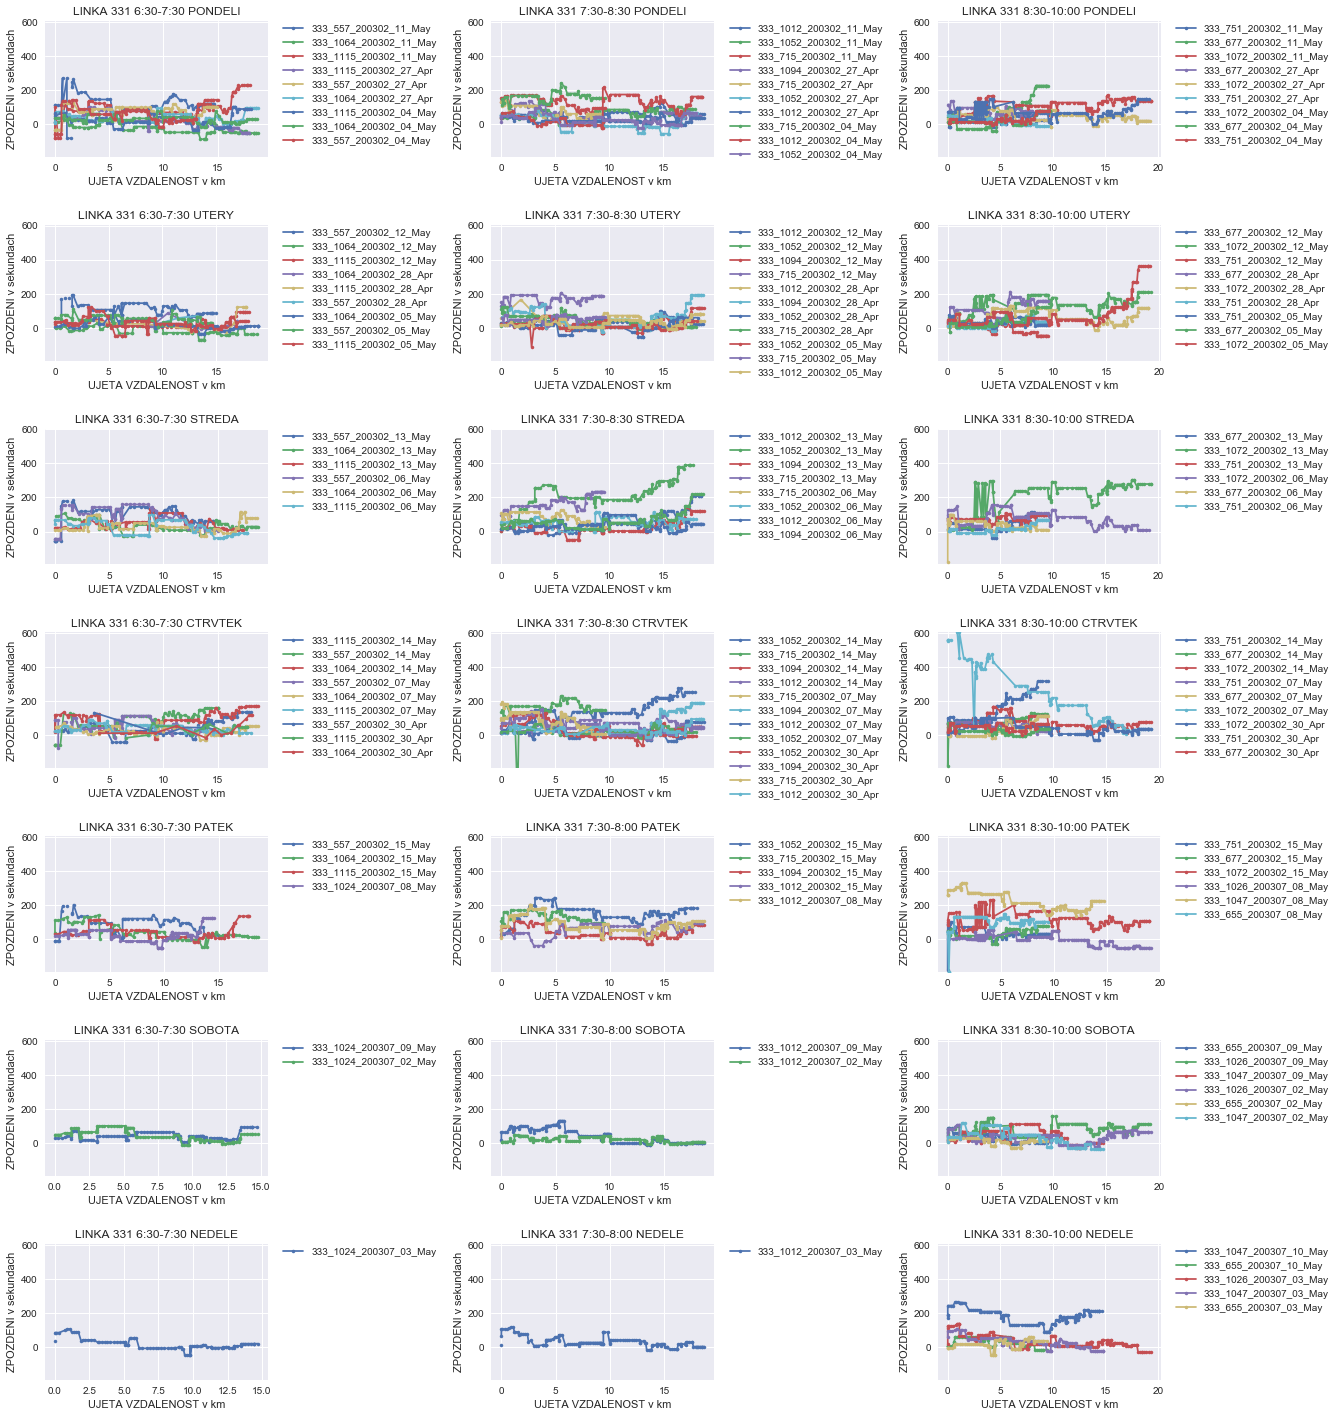

In [19]:
n_days = 7
n_times = 3

fig, axes = plt.subplots(nrows=n_days, ncols=n_times, figsize=(20,25))
min_y = 500
max_y = -100

days = [lines1, lines2, lines3]
labels = [
    ['LINKA 333 6:30-7:30 PONDELI','LINKA 333 6:30-7:30 UTERY','LINKA 333 6:30-7:30 STREDA','LINKA 333 6:30-7:30 CTRVTEK','LINKA 333 6:30-7:30 PATEK','LINKA 333 6:30-7:30 SOBOTA','LINKA 333 6:30-7:30 NEDELE'],
    ['LINKA 333 7:30-8:30 PONDELI','LINKA 333 7:30-8:30 UTERY','LINKA 333 7:30-8:30 STREDA','LINKA 333 7:30-8:30 CTRVTEK','LINKA 333 7:30-8:00 PATEK','LINKA 333 7:30-8:00 SOBOTA','LINKA 333 7:30-8:00 NEDELE'],
    ['LINKA 333 8:30-10:00 PONDELI','LINKA 333 8:30-10:00 UTERY','LINKA 333 8:30-10:00 STREDA','LINKA 333 8:30-10:00 CTRVTEK','LINKA 333 8:30-10:00 PATEK','LINKA 333 8:30-10:00 SOBOTA','LINKA 333 8:30-10:00 NEDELE']
]

for i in range(n_times):
    plot_column(n_days, i, days[i], labels[i], axes, min_y, max_y)
    
#axes.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.style.use('seaborn')
plt.subplots_adjust(hspace=0.5, wspace=1)

In [ ]:
# fig, axes = plt.subplots(nrows = 3, ncols = 2,figsize=(16,10))  
# min_y = 500
# max_y = -100
# for day, label in zip([po_rano_centrum_331_1, ut_rano_centrum_331_1, ct_rano_centrum_331_1],['LINKA 331 6:30-7:30 PONDELI','LINKA 331 6:30-7:30 UTERY','LINKA 331 6:30-7:30 CTRVTEK']):
#     print(day)
#     for i in range(len(day)):
#         uni = day[i]
#         columns = data[data['UNICORN'] == uni][['DELAY_STOP_DEPARTURE','SHAPE_DIST_TRAVELED']].sort_values(by='SHAPE_DIST_TRAVELED')
# #min_y = columns['DELAY_STOP_DEPARTURE'].min() < min_y ? columns['DELAY_STOP_DEPARTURE'].min() : min_y
#         min_y = min(columns['DELAY_STOP_DEPARTURE'].min(), min_y)
#         max_y = max(columns['DELAY_STOP_DEPARTURE'].max(), max_y)
#         axes[i][0].plot(columns['SHAPE_DIST_TRAVELED'],columns['DELAY_STOP_DEPARTURE'], linestyle = '-', marker = '.',label=uni)
#         axes[i][0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad=0.)
#         axes[i][0].set_xlabel('UJETA VZDALENOST v km')
#         axes[i][0].set_ylabel('ZPOZDENI v sekundach')
#         axes[i][0].set_title(label)

# for day, label in zip( [po_rano_centrum_331_2, ut_rano_centrum_331_2,ct_rano_centrum_331_2], ['LINKA 331 7:30-8:30 PONDELI','LINKA 331 7:30-8:30 UTERY','LINKA 331 7:30-8:30 CTRVTEK'] 
#                      ):
#     for i in range(len(day)):
#         uni = day[i]
#         columns = data[data['UNICORN']== uni][['DELAY_STOP_DEPARTURE','SHAPE_DIST_TRAVELED']].sort_values(by='SHAPE_DIST_TRAVELED')
#         min_y = min(columns['DELAY_STOP_DEPARTURE'].min(), min_y)
#         max_y = max(columns['DELAY_STOP_DEPARTURE'].max(), max_y)
#         axes[i][1].plot(columns['SHAPE_DIST_TRAVELED'],columns['DELAY_STOP_DEPARTURE'], linestyle = '-', marker = '.',label=uni)
#         axes[i][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad=0.)
#         axes[i][1].set_xlabel('UJETA VZDALENOST v km')
#         axes[i][1].set_ylabel('ZPOZDENI v sekundach')
#         axes[i][1].set_title(label)
# for ax in axes:
#     for x in ax:
#         x.set_ylim(min_y, max_y)
# plt.style.use('seaborn')
# plt.subplots_adjust(hspace=0.5, wspace=0.8)
# plt.show()